In [24]:
import pandas as pd
from scipy import signal, interpolate
import numpy as np
from matplotlib import pyplot as plt

In [25]:
def filter(ndvi, cond):
    length = len(ndvi)

    filtered_ndvi = ndvi.copy() 
    filtered_ndvi = filtered_ndvi[cond]

    x = np.linspace(0, length-1, num=length)
    x = x[cond]

    return length, x, filtered_ndvi

In [26]:
def interpol(x, filtered_ndvi, length, spline=False):
    new_x = np.linspace(0, length-1, num=length)
    if spline:
        slp = interpolate.CubicSpline(x, filtered_ndvi)
        return slp(new_x)
    
    return np.interp(new_x, x, filtered_ndvi)

In [27]:
def merge_ndvi(ndvi, gol_ndvi):
    cond = ndvi > gol_ndvi
    final_ndvi = gol_ndvi.copy()
    final_ndvi[cond] = ndvi[cond]

    return final_ndvi

In [28]:
def compute_f_metric(ref_ndvi, gol_ndvi):
    dist = np.abs(gol_ndvi - ref_ndvi)
    max_dist = np.max(dist)
    w = np.ones(shape=dist.shape)
    cond = gol_ndvi > ref_ndvi
    w[cond] = 1 - dist[cond] / max_dist

    return np.dot(dist, w)

In [29]:
def restore_ndvi(ndvi, cond):
    length, x, filtered_ndvi = filter(ndvi, cond)
    inter_ndvi = interpol(x, filtered_ndvi, length, spline=True)
    gol_ndvi = signal.savgol_filter(inter_ndvi, 5, 3)
    final_ndvi = merge_ndvi(ndvi, gol_ndvi)

    return final_ndvi

In [30]:


path_ndvi =  'ndvi_sample_v3.csv'
path_scl = 'scl_sample_v3.csv'

In [31]:
ndvi_data = pd.read_csv(path_ndvi, index_col=0, parse_dates=['data'])
scl_data = pd.read_csv(path_scl, index_col=0)


In [32]:
dates = ndvi_data.data.values
print(ndvi_data)

         data       0     0.1     0.2     0.3     0.4     0.5     0.6     0.7  \
0  2020-05-24 -0.5849  0.6993  0.7430  0.5944  0.7169  0.4480  0.8051  0.3356   
1  2020-06-09 -0.3739  0.6536  0.6937  0.5045  0.6529  0.5563  0.7770  0.3749   
2  2020-06-25 -0.2745  0.6215  0.6546  0.4516  0.6140  0.5695  0.7694  0.4466   
3  2020-07-11 -0.2807  0.5957  0.6279  0.4255  0.6005  0.5496  0.7557  0.4708   
4  2020-07-27 -0.1224  0.5664  0.5809  0.3847  0.5362  0.5223  0.7063  0.5070   
5  2020-08-12 -0.1236  0.5235  0.5596  0.3592  0.4995  0.5744  0.7004  0.5234   
6  2020-08-28 -0.0332  0.4487  0.4758  0.3377  0.4311  0.4347  0.6515  0.4874   
7  2020-09-13  0.0068  0.4469  0.4742  0.3268  0.4048  0.4736  0.5767  0.4783   
8  2020-09-29  0.0273  0.4845  0.5242  0.2940  0.4423  0.4171  0.6067  0.5009   
9  2020-10-15  0.0401  0.0234  0.0062  0.0628  0.0506  0.0990  0.0448  0.0561   
10 2020-10-31 -0.0384  0.1398  0.6784  0.4103  0.1313  0.7387  0.6799  0.6338   
11 2020-11-16 -0.0474  0.740

In [17]:
ndvi = ndvi_data['2022-09-30'].values
scl = scl_data['2022-09-30'].values
cond = (scl >=4) & (scl <=7)

length, x, filtered_ndvi = filter(ndvi, cond)
inter_ndvi = interpol(x, filtered_ndvi, length, spline=True)
gol_ndvi = signal.savgol_filter(inter_ndvi, 5, 3)

dist = compute_f_metric(ndvi, gol_ndvi)

KeyError: '2022-09-30'

NameError: name 'ndvi' is not defined

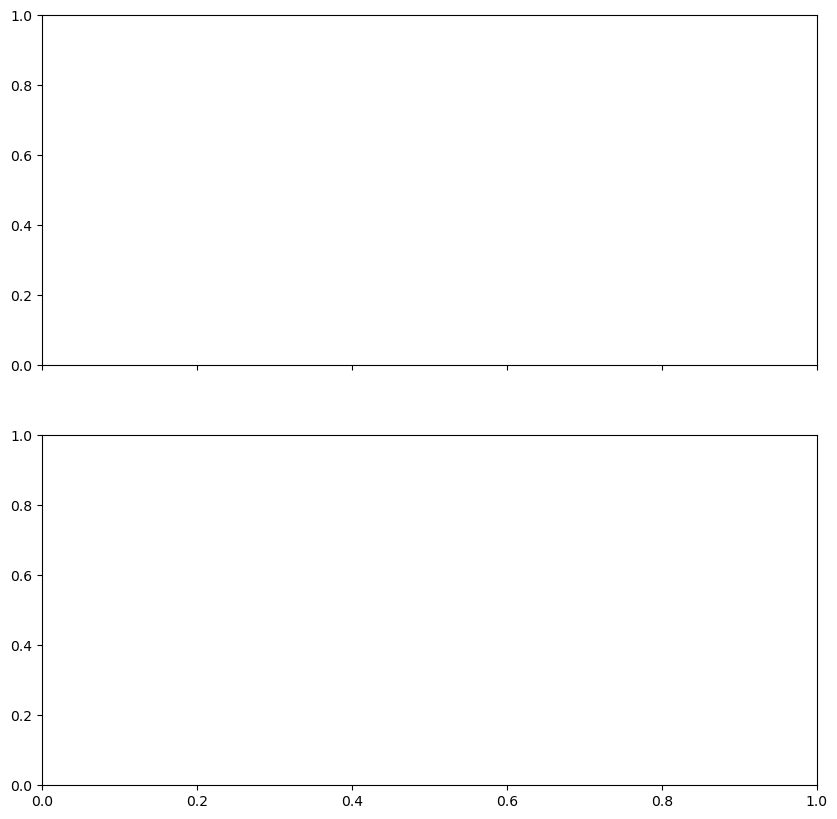

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,10))

ax[0].plot(dates, ndvi, 'bo--', alpha=0.5, label='Obs')
ax[1].plot(dates, scl, color='red', linewidth=0.7, label=f'SG')
# ax.plot(ndvi['data'], int_ndvi, 'r--', linewidth=0.5, label='Int')


ax[1].set_xlabel('Data')
ax[0].set_ylabel('NDVI')
ax[1].set_ylabel('SCL')
ax.legend()

plt.show()

NameError: name 'ndvi' is not defined

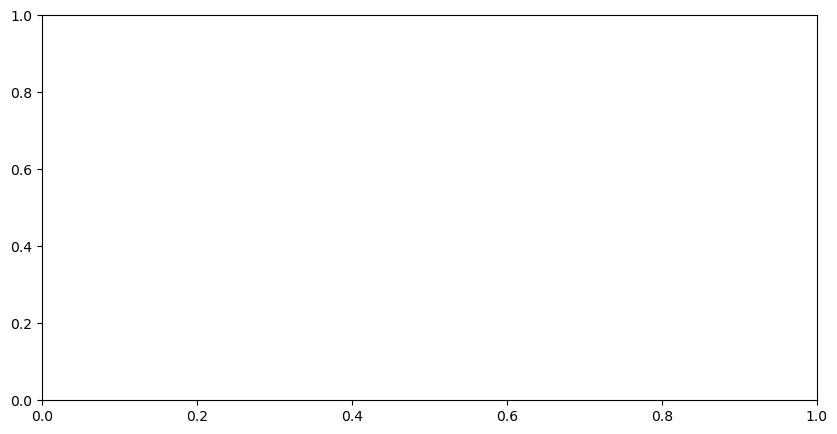

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(dates, ndvi * cond, 'bo--', alpha=0.5, label='Obs')
ax.plot(dates, gol_ndvi, color='red', linewidth=0.7, label=f'SG')
# ax.plot(ndvi['data'], int_ndvi, 'r--', linewidth=0.5, label='Int')


ax.set_xlabel('Data')
ax.set_ylabel('NDVI')
ax.legend()

plt.show()

In [29]:
final_ndvi = merge_ndvi(ndvi, gol_ndvi)
dist = compute_f_metric(ndvi, final_ndvi)

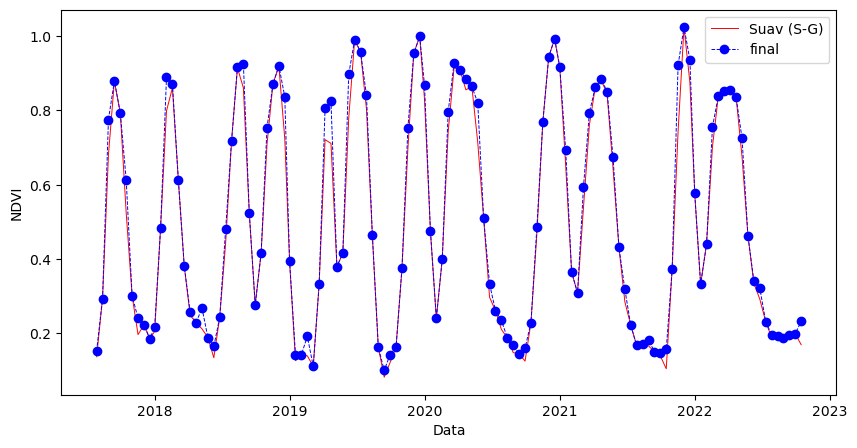

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(dates, gol_ndvi, color='red', linewidth=0.7, label='Suav (S-G)')
ax.plot(dates, final_ndvi, 'o--', color='blue', linewidth=0.7, label='final')
# ax.plot(ndvi['data'], int_ndvi, 'r--', linewidth=0.5, label='Int')


ax.set_xlabel('Data')
ax.set_ylabel('NDVI')
ax.legend()

plt.show()

### Séries de NDVI reconstruídas

In [33]:
new_ndvi = pd.DataFrame({'data': ndvi_data.data})


for col in ndvi_data.drop(columns=['data']).columns:

    ndvi = ndvi_data[col].values
    scl = scl_data[col].values

    cond = (scl >=4) & (scl <=7)  # Condição de Filtragem


    new_ndvi[col] = restore_ndvi(ndvi, cond)

/tmp/ipykernel_681406/4228433863.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_ndvi[col] = restore_ndvi(ndvi, cond)
/tmp/ipykernel_681406/4228433863.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_ndvi[col] = restore_ndvi(ndvi, cond)
/tmp/ipykernel_681406/4228433863.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [34]:
new_ndvi

,data,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,1.160,1.161,1.162,1.163,1.164,1.165,1.166,1.167,1.168,1.169
0,2020-05-24,-0.584900,0.699336,0.743499,0.594847,0.717993,0.448519,0.805143,0.335600,0.757984,...,0.736540,0.737879,0.602200,0.766444,0.558500,0.577100,0.675267,0.725559,0.575339,0.675500
1,2020-06-09,-0.358809,0.653600,0.693700,0.504500,0.652900,0.556300,0.777000,0.382866,0.751400,...,0.702800,0.680700,0.535923,0.757900,0.504677,0.531903,0.616500,0.684900,0.521500,0.624054
2,2020-06-25,-0.274500,0.621714,0.657591,0.454283,0.620557,0.572611,0.769657,0.446600,0.711106,...,0.671840,0.648171,0.495500,0.730566,0.484600,0.496500,0.568803,0.650751,0.489631,0.591600
3,2020-07-11,-0.229777,0.595726,0.627900,0.425500,0.600500,0.549600,0.755700,0.478626,0.676800,...,0.674800,0.627400,0.459200,0.700200,0.453700,0.461200,0.538200,0.620400,0.467800,0.555400
4,2020-07-27,-0.122400,0.567103,0.592403,0.388240,0.548003,0.552986,0.720503,0.507069,0.652271,...,0.645800,0.585680,0.418817,0.677971,0.411929,0.422269,0.486980,0.585180,0.441489,0.517309
5,2020-08-12,-0.091393,0.523500,0.559600,0.359200,0.499500,0.574400,0.700400,0.523400,0.642000,...,0.600686,0.541500,0.378600,0.661500,0.377500,0.392500,0.441100,0.550400,0.419800,0.476700
6,2020-08-28,-0.033200,0.460571,0.490826,0.341051,0.435566,0.489934,0.651500,0.493786,0.603400,...,0.585240,0.504977,0.337543,0.630200,0.335117,0.361089,0.400540,0.511240,0.355826,0.420814
7,2020-09-13,0.018877,0.446900,0.474200,0.326800,0.439285,0.473600,0.596588,0.478300,0.564960,...,0.585700,0.486500,0.326400,0.585780,0.312100,0.337500,0.381500,0.501924,0.320400,0.401100
8,2020-09-29,0.029914,0.484500,0.524834,0.294000,0.442300,0.465858,0.606700,0.503675,0.593800,...,0.549911,0.496560,0.345889,0.563600,0.316666,0.351890,0.363096,0.534100,0.363273,0.436013
9,2020-10-15,0.040100,0.544537,0.604553,0.301990,0.177353,0.586860,0.640125,0.562578,0.670850,...,0.578524,0.572916,0.418092,0.520851,0.376999,0.420808,0.414667,0.597973,0.434165,0.529335


In [35]:
new_ndvi.to_csv( 'filtered_filled_ndvi_sample_v3.csv', index=False)